<a href="https://colab.research.google.com/github/preritt/KProj/blob/master/Cifar10BaselineVer02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
from keras.callbacks import ModelCheckpoint

In [0]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [0]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    elif epoch > 100:
        lrate = 0.0003        
    return lrate

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [0]:
#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

In [0]:
num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

In [0]:
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
__________

In [0]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

In [0]:
continue_training = False
if continue_training:
   model.load_weights('weights.hdf5')

In [0]:
mcp_save = ModelCheckpoint('weights.hdf5', save_best_only=True, monitor='val_loss', mode='auto')



In [23]:
#training
batch_size = 64

opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=60,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[mcp_save, LearningRateScheduler(lr_schedule)])

Instructions for updating:
Use tf.cast instead.
Epoch 1/60
781/781 [==============================] - 55s 70ms/step - loss: 1.8872 - acc: 0.4270 - val_loss: 1.5231 - val_acc: 0.5582
Epoch 2/60
781/781 [==============================] - 50s 64ms/step - loss: 1.2531 - acc: 0.5967 - val_loss: 1.0816 - val_acc: 0.6604
Epoch 3/60
781/781 [==============================] - 50s 64ms/step - loss: 1.0672 - acc: 0.6590 - val_loss: 0.9269 - val_acc: 0.7166
Epoch 4/60
781/781 [==============================] - 50s 64ms/step - loss: 0.9741 - acc: 0.6917 - val_loss: 0.8749 - val_acc: 0.7379
Epoch 5/60
781/781 [==============================] - 50s 64ms/step - loss: 0.9073 - acc: 0.7176 - val_loss: 0.9119 - val_acc: 0.7326
Epoch 6/60
781/781 [==============================] - 50s 64ms/step - loss: 0.8562 - acc: 0.7392 - val_loss: 0.9353 - val_acc: 0.7318
Epoch 7/60
781/781 [==============================] - 50s 64ms/step - loss: 0.8249 - acc: 0.7522 - val_loss: 0.7653 - val_acc: 0.7814
Epoch 8/60
781

In [0]:

model.load_weights('weights.hdf5')
model.save('BaselineCifar10Model.h5')

In [0]:
from matplotlib import pyplot as plt


In [0]:
#save to disk
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

model.save_weights('model.h5') 

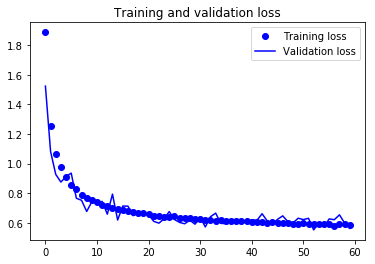

In [29]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
epochs = range(60)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

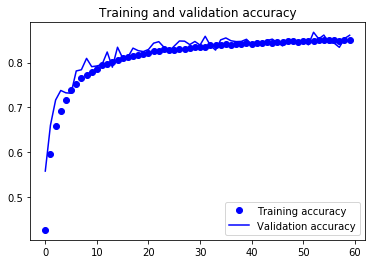

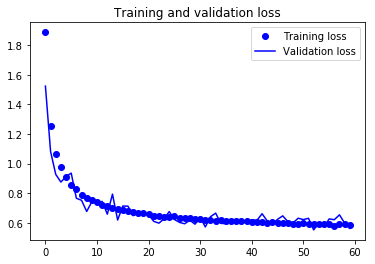

In [30]:
accuracy = model.history.history['acc']
val_accuracy = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
predicted_classes = model.predict(x_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
orig_classes = np.argmax(np.round(y_test),axis=1)

In [0]:
from sklearn.metrics import confusion_matrix

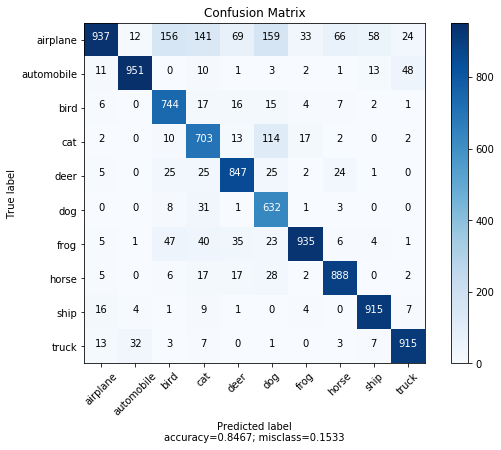

In [34]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
plot_confusion_matrix(cm           = confusion_matrix(predicted_classes, orig_classes), 
                      normalize    = False,
                      target_names = class_names,
                      title        = "Confusion Matrix")

In [35]:
cm = confusion_matrix(predicted_classes, orig_classes)
per_class_accuracy  = np.diag(cm)
per_class_accuracy

array([937, 951, 744, 703, 847, 632, 935, 888, 915, 915])

In [36]:
np.diag(cm/cm.sum(axis=1)[:,None])

array([0.56616314, 0.91442308, 0.91625616, 0.81460023, 0.88784067,
       0.93491124, 0.85232452, 0.92020725, 0.95611285, 0.93272171])

In [37]:
from sklearn.metrics import classification_report
target_names = class_names
print(classification_report(orig_classes, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

    airplane       0.57      0.94      0.71      1000
  automobile       0.91      0.95      0.93      1000
        bird       0.92      0.74      0.82      1000
         cat       0.81      0.70      0.75      1000
        deer       0.89      0.85      0.87      1000
         dog       0.93      0.63      0.75      1000
        frog       0.85      0.94      0.89      1000
       horse       0.92      0.89      0.90      1000
        ship       0.96      0.92      0.94      1000
       truck       0.93      0.92      0.92      1000

   micro avg       0.85      0.85      0.85     10000
   macro avg       0.87      0.85      0.85     10000
weighted avg       0.87      0.85      0.85     10000



In [38]:
#testing
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 1s 135us/step

Test result: 86.770 loss: 0.551
